# Imports

In [10]:
import numpy as np # Pour les math
import matplotlib.pyplot as plt # Pour les graphiques
import cvxpy as cp
import time
from scipy.optimize import linprog # Notre solveur

# Données et Utils

In [11]:
# NOS CONSTANTES POUR TOUT LE PROJET : 
COP_CONST = 3.2
CAPACITE_CALORIFIQUE = 0.4
MIN_TEMP = 19
MAX_TEMP = 21
ETA  = 0.99

In [12]:
temperatures_exterieurs = np.load("Temperatures-Montreal.npy")
print(temperatures_exterieurs[0])

-0.8299999999999841


In [13]:
def is_night(idx):
    days_offset = 96
    day = (idx % days_offset)
    return True if day > 88 or day < 28 else False


def get_cop(reference, outside_temperature , x_i):
    
    if (reference < outside_temperature):
        return ((COP_CONST,1), COP_CONST * CAPACITE_CALORIFIQUE * x_i) 
    else:
        COP_TEX = 3 + 10 * abs(np.tanh(outside_temperature/100)) * np.tanh(outside_temperature/100)
        return ((COP_TEX, 0), COP_TEX * CAPACITE_CALORIFIQUE * x_i)
   

# Résolution du système
## Variables de décison
Soit $x_i$ l'énergie utiliser en mode normale par la pompe à chaleur à l'intervalle de temps i. \

## Objectif 
Minimiser le coût total de l'électricité consommée par la pompe à chaleur. \

Fonction objective: \
min $c^T * abs(x_i)$

où c_i est le coût de l'électricité à l'intervalle de temps i. \
$c_i = 0.18$ si c'est la nuit \
ou \
$c_i = 0.26$ si c'est le jour \
et où $abs(x_i)$ est l'énergie utilisée.

## Contraintes
$x_i \le (1)$ \
$x_i \ge (-1)$ \
$x_i \ge (19-t_i)* (1/0.4) * (1/COP_{xi})$ \
$x_i \le (21-t_i)*(1/0.4) * (1/COP_{xi})$ \
$x_i \ge -(21-t_i)(1/0.4) * (1/3.2)$ \
$x_i \le -(19-t_i)*(1/0.4) * (1/3.2)$ \
$t_{{in}_{i+1}} - t_{{in_final}_i} = -0.01 * (t_{{in_final}_i} - t_{{ex}_i})$ \
$COP_{xi} = 3 + 10 * abs(tanh(t_{{ex}_i}/100)) * tanh(t_{{ex}_i}/100)$ \
où $t_i$ est la température intérieur initiale à l'intervalle de temps i, $COP_{xi}$ le coefficent de performance de la pompe à chaleur en mode noramel à l'intervalle de temps i, $t_{{in_final}_i}$ la température à l'intérieur après avoir utilisé (ou non) la pompe à chaleur à l'intervalle de temps i et $t_{{ex}_i}$ est la température extérieur de Montréal à l'interval de temps i.


# Système entier


In [14]:
def task_1(i_idx):
    depart = time.time()
    days_offset = 96
    end_idx = i_idx + days_offset*7

    valeur_energie = []
    cout_intervalle = []
    
    T0 = 20 # température de départ
    
    x = cp.Variable(end_idx-i_idx)
    Tin = cp.Variable(end_idx-i_idx)
    contraintes = [Tin[0] == T0, Tin[end_idx-i_idx-1] == T0]
    
    cout_intervalle.append(0.18) if is_night(i_idx) else cout_intervalle.append(0.26)
    for i in range(1, end_idx-i_idx):
        cout_intervalle.append(0.18) if is_night(i + i_idx) else cout_intervalle.append(0.26)


        T1 = -(1 - ETA) * (Tin[i-1] - temperatures_exterieurs[i+ i_idx]) + Tin[i-1] #température initial suivante
        
        current_cop, degre_a_compenser = get_cop(20, temperatures_exterieurs[i+ i_idx], x[i])
        
        # Contrainte de degrée
        contraintes += [(T1 + degre_a_compenser == Tin[i])]
        contraintes += [-Tin[i] <= -MIN_TEMP, Tin[i] <= MAX_TEMP]
        
        # Contrainte d'énergie
        contraintes += [x[i] <= 1, x[i] >= -1]

    fonction_cout = cp.sum(cp.multiply(cout_intervalle, cp.abs(x)))
    solution = cp.Problem(cp.Minimize(fonction_cout), contraintes)
    solution.solve()

    fin = time.time() - depart
    valeur_energie = x.value
    cout_intervalle = x.value * cout_intervalle
    valeur_température = Tin.value 
    
    print(f"Le coût minimal est pour l'intance {i_idx} est: {solution.value} ")
    print(f"Temps de calcul:  {fin} ")    

    
    return (solution.value, Tin, temperatures_exterieurs, x.value)


def display_temperature(Tin, temperatures_exterieurs, start_idx):
    axe_x = range(672)
    
    fig, ax = plt.subplots()
    ax.add_patch(plt.Rectangle((0, MIN_TEMP), 672, (MAX_TEMP - MIN_TEMP), alpha=.2))
    ax.plot(axe_x, Tin.value, label="Temperature intérieur", color="red")
    ax.plot(axe_x, temperatures_exterieurs[start_idx:start_idx+672], label="Temperature extérieur", color="black")

    plt.legend()
    plt.title("Comparaison entre la température extérieur et intérieur")
    plt.xlabel("Interval de temps de 15 minutes")
    plt.show()
    
def display_energy(valeur_energie):
    axe_x = range(672)
    refroidissement = []
    rechauffement = []
    
    for i in valeur_energie:
        if i < 0:
            refroidissement.append(i)
            rechauffement.append(0)
        else:
            rechauffement.append(i)
            refroidissement.append(0)
    fig, ax = plt.subplots()
    ax.bar(axe_x, rechauffement, label="Pour réchauffer", color="red")
    ax.bar(axe_x, refroidissement, label="Pour refroidir", color="black")
    plt.legend()
    plt.title("Energie utilisé par la pompe à chaleur")
    plt.xlabel("Interval de temps de 15 minutes")
    plt.show()

In [15]:
min_cost, temperature_in, temperature_ext, énergie = task_1(13050)
min_cost2, temperature_in2, temperature_ext2, énergie2 = task_1(18500)

Le coût minimal est pour l'intance 13050 est: 8.10396380565292 
Temps de calcul:  3.975375175476074 
Le coût minimal est pour l'intance 18500 est: 2.414674662968298 
Temps de calcul:  3.507596492767334 


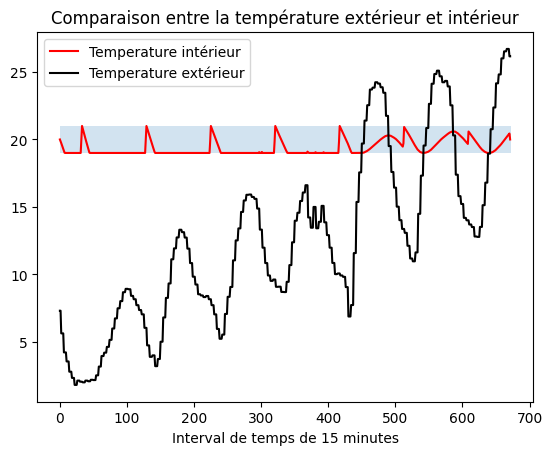

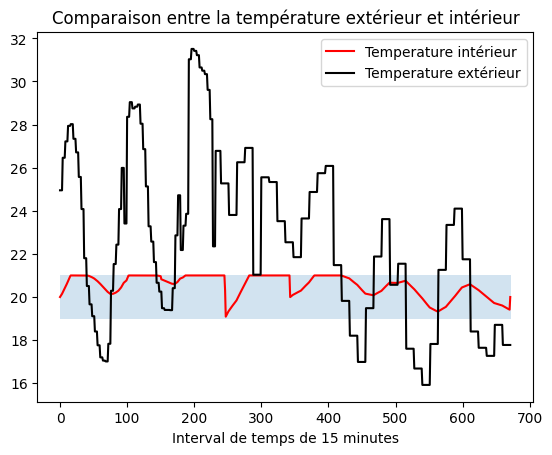

In [16]:
display_temperature(temperature_in, temperature_ext, 13050)
display_temperature(temperature_in2, temperature_ext2, 18500)

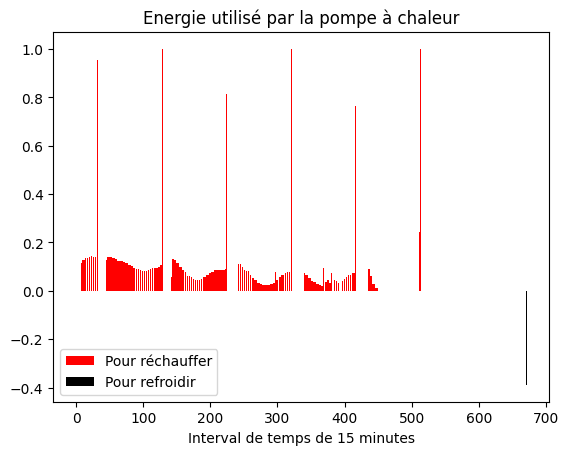

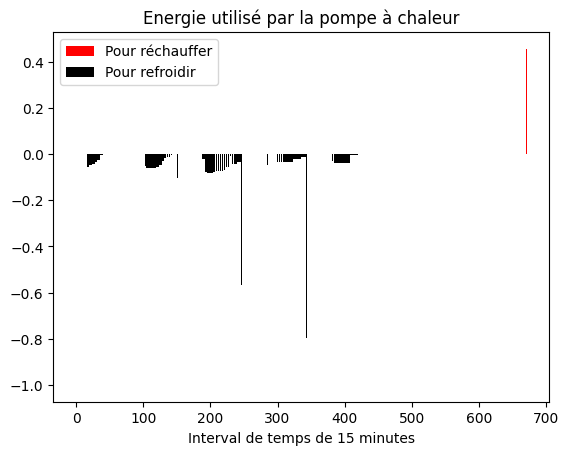

In [17]:
display_energy(énergie)
display_energy(énergie2)

# Commentaire
Les résultats observés sur nos graphes sont satisfaisant, on voit que toutes les contraintes du problème sont satisfaites. (Une energie négative dans le graphe ne représente pas un gain d'énergie mais l'énergie dépensée en mode reverse) \
Nous avons choisi d'observer cette deuxième semaine en particulier car elle est très chaude et permet d'observer que la contrainte x_i >= -1 est respéctée.


# Tâche 2 

## Variables de décision
Soit $I_i$ l'inconfort à l'intervale $i$
Soit $c_i$ le coût à l'intervale $i$
## Objectif
Minimiser l'inconfort total
$\sum_{i = 0}^{n} I_i$ 

Étant donné que l'inconfort à l'intervale $i$ peut être définis comme ceci :
$
\begin{cases}
I_i = I_i + 3 & T_i < T\_min \\
I_i = I_i + 1 & T_i > T\_max \\
0 & sinon\\
\end{cases}
$

Mais avec un petit tricks on peut la noter d'une manière plus "linéaire" en effet on aimerait que quand $T_i \ge T\_max$ ça fait qqch ou sinon rien. Grâce à la fonction max on peut transformer ce système une simple équation du style.\
$
I_i = 3* max(T\_min - T_i, 0) + 1 * max(T_i - T\_max, 0) 
$

## Contraintes
$\sum_{i = 0}^{n} c_i \leq$ MAX\_BUDGET

In [18]:
def task_2(min_cost, start_idx):
    MIN_PENALITY = 3
    MAX_PENALITY = 1
    #TODO ICI
    #MAX_BUDGET = min_cost * 2 #todo à connaître le rapport entre les 2
    MAX_BUDGET = 5
    days_offset = 96
    end_idx = start_idx + days_offset*7
    
    Tin = cp.Variable(end_idx - start_idx) # température
    x = cp.Variable(end_idx - start_idx) # énergie
    
    T0 = 20
    
    contraintes = [Tin[0] == T0]
    cout_elec = []
        
    for i in range(0, end_idx - start_idx):
        cout_elec.append(0.18) if is_night(i + start_idx) else cout_elec.append(0.26)
        
        T1 = -(1 - ETA) * (Tin[i-1] - temperatures_exterieurs[i+ start_idx]) + Tin[i-1]
        
        current_cop, degre_a_compenser = get_cop(20, temperatures_exterieurs[i+ start_idx], x[i])
        
        contraintes.append(T1 + degre_a_compenser == Tin[i])
    
    contraintes.append(cp.sum(cp.multiply(cout_elec, cp.abs(x))) <= MAX_BUDGET)
    
    inconfort_func = lambda T : MIN_PENALITY * cp.maximum(MIN_TEMP - T, 0) + MAX_PENALITY * cp.maximum(T - MAX_TEMP , 0)
    
    minimise_function = cp.sum(list(map(inconfort_func, Tin)))
    
    solution = cp.Problem(cp.Minimize(minimise_function), contraintes)
    solution.solve()
    print("Solution pour avoir un inconfort minimal est de :", solution.value)
    
    return (solution.value, Tin)

In [ ]:
min_inconfort, temperature_in = task_2(min_cost, 13050)

In [ ]:
display_temperature(temperature_in, temperature_ext, 13050)

# Commentaire

# Tâche 3 

## Objectif
Proposer et générer un graphe représentant la relation entre budget et inconfort

In [2]:
#Calcule des donées nécessaires
inconfort_total_sur_8_budgets_ref = []
inconfort_total_sur_8_budgets_2 = []

budget = [0, 1, 2, 3, 4, 5, 6, 7, 8]
print(budget)
for i in range(8):


    inconfort_total_sur_8_budgets_ref.append(task_2(budget[i], 13050)[0])
    inconfort_total_sur_8_budgets_2.append(task_2(budget[i], 18500)[0])
#Création du graphe
def display_inconfort_budget(list_inconfort, list_budget):
    axe_x = range(8)
    fig, ax = plt.subplots()
    ax.bar(axe_x, list_inconfort, label="Inconfort total", color="red")
    plt.legend()
    plt.title("Inconfort total en fonction du budget alloué")
    plt.xlabel("Budget")
    plt.show()
display_inconfort_budget(inconfort_total_sur_8_budgets_ref, budget)
display_inconfort_budget(inconfort_total_sur_8_budgets_2, budget)


range(0, 8)


# Commentaire